In [1]:
import numpy as np
import os
import math
import json
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
class Projection():
    #The main class that represents the projection of the bipartite graph as described in the report.
    #Contains all necessary loading and processing routines to import the precomputed graphs, as
    #well as clustering and plotting methods.
    def __init__(self, in_dir, benchmark, chan_w, include_tsne = False):
        local_dir = in_dir + '/' + benchmark + '/' + benchmark + '.' + str(chan_w) + '/'
        self.projection_file = local_dir + "projection.dump"
        self.coord_file = local_dir + "coords.dump"
        self.cp_file = local_dir + benchmark + ".critical_path.out"
        self.circ_file = local_dir + benchmark + ".circ"
        self.rlb_file = local_dir + benchmark + ".rlb"
        
        self.G = self.prune_isolated(self.load_projection())
        self.nodes = sorted(list(self.G.nodes()))
        self.adjacency = np.array(nx.to_numpy_matrix(self.G, nodelist = self.nodes, weight = 'w'))
        self.load_coordinates(self.G)
        self.read_critical_path()
                   
        self.G_tsne = None
        if include_tsne:
            self.G_tsne = self.relabel(self.read_graph(True))
            self.load_coordinates(self.G_tsne)
        
    def load_projection(self):
        #Loads a previously dumped projection graph.
    
        dump = open(self.projection_file, "r")
        lines = dump.readlines()
        dump.close()
    
        node_no = int(lines[0].split()[0])
        edge_no = int(lines[0].split()[1])
    
        nodes = {}
        graph = nx.Graph()
        for lptr in range(1, node_no + 1):
            num_id = int(lines[lptr].split()[0])
            str_id = lines[lptr].split()[1]
            crit = float(lines[lptr].split()[2])
            nodes.update({num_id : str_id})
            graph.add_node(str_id, crit = crit)
    
        lptr += 1
        for lptr in range(lptr, node_no + 1 + edge_no):
            u = int(lines[lptr].split()[0])
            v = int(lines[lptr].split()[1])
            w = float(lines[lptr].split()[2])
            graph.add_edge(nodes[u], nodes[v], w = w)

        return graph
   
    def prune_isolated(self, G):
        #Removes isolated nodes.
        
        nodes = list(G.nodes())
        for u in nodes:
            if G.degree(u) == 0:
                G.remove_node(u)
    
        return G
    
    def load_coordinates(self, G):
        #Loads coordinates determined during placement and
        #assigns them as node attributes.
        
        cf = open(self.coord_file, "r")
        lines = cf.readlines()
        cf.close()
        for line in lines:
            u = line.split()[0]
            x = int(line.split()[1])
            y = int(line.split()[2])
            try:
                G.node[u]["coords"] = (x, y)
            except:
                pass
    
    def read_critical_path(self):
        #Reads the critical path.

        cp = open(self.cp_file, "r")
        lines = cp.readlines()
        cp.close()

        cp = []
        for line in lines:
            if "Internal Net" in line or "External-to_Block Net" in line:
                u = line.split('(', 1)[1].split(')', 1)[0]
                if not cp or cp[-1] != u:
                    cp.append(u)

        self.cp = cp
            
    def read_graph(self, include_tsne = False):                                                 
        #Reads the circuit (blif) graph itself.                                                                    
    
        type_ids = ["lut", "ff", "i"]                                                               
    
        g = open(self.circ_file, "r")                                                                     
        lines = g.readlines()                                                                       
        g.close()                                                                                   
    
        col_shift = 0                                                                               
        if include_tsne:                                                                            
            col_shift = 1                                                                           

        G = nx.DiGraph()                                                                            
        cnt = 1                                                                                     
        for line in lines[1:]:                                                                      
            words = line.split()                                                                    
            node_type = type_ids[int(words[0 + col_shift])]                                         
            outdeg = int(words[1 + col_shift])                                                      
            G.add_node(cnt, node_type = node_type)                                                  
            if include_tsne:                                                                        
                tsne = int(words[0])                                                                
                G.node[cnt]["tsne"] = tsne                                                          
            if outdeg:                                                                              
                for w in words[col_shift + 2:]:                                                     
                    G.add_edge(cnt, int(w))                                                         
            cnt += 1                                                                                

        return G
    
    def relabel(self, G):
        #Reads the relabeling dictionary and relabels the graph nodes.

        rlb = open(self.rlb_file, "r")
        lines = rlb.readlines()
        rlb.close()

        rlb_dict = {}
        cnt = 0
        for line in lines[1:]:
            cnt += 1
            rlb_dict.update({cnt : line.strip()})

        return nx.relabel_nodes(G, rlb_dict)
    
    #Clustering routines go here:
    
    def calc_cluster_weight(self, cls, with_nodes = False):
        #Computes the weight of the given cluster, either as the average of its
        #edge weights, or the average of products of the edge weigths and their
        #endpoint weights.

        weight = 0
        card = 0
        for u in cls:
            for v in cls:
                if self.G.has_edge(u, v):
                    e_w = self.G[u][v]['w']
                    if with_nodes:
                        u_w = self.G.node[u]["crit"]
                        v_w = self.G.node[v]["crit"]
                        weight += u_w * v_w * e_w
                    else:
                        weight += e_w
                    card += 1
    
        return weight / card if card else 0
    
    def cluster(self, k):
        #Runs the clustering itself and computes the cluster weights, assigning the nodes
        #sizes in proportion to them.
        spectral_clustering = SpectralClustering(self.adjacency, k)
        y_pred = spectral_clustering.fit_predict()

        sizes = [0 for u in self.nodes]
        cls_list = []
        for i in range(0, k):
            cls = []
            for j in range(0, len(y_pred)):
                if y_pred[j] == i:
                    cls.append(self.nodes[j])
            weight = self.calc_cluster_weight(cls, True)
            cls_list.append([cls, weight])
            for u in cls:
                sizes[self.nodes.index(u)] = weight

        self.cls_list = cls_list
        self.sizes = sizes
        self.colors = y_pred
        
    #Plotting routines go here:
    
    def plot_graph(self, G, cls_size = 10):
        #Determines the scatter point coordinates, given the cluster_size.
        freq = {}
        xs = []
        ys = []
        for u in self.nodes:        
            coords = G.node[u]["coords"]
            f = freq.get(coords, 0)
            xs.append(coords[0])
            ys.append(coords[1] + 1.0 / cls_size * f)
            freq.update({coords : f + 1})

        return xs, ys
    
    def plot_clustered(self, k, r = 60, fig = None, ax = None, fig_w = 10, fig_h = 10):
        #Performs the actual plotting of the projection scatter on the FPGA grid.
        #"k" determines the number of (graph-theoretic) clusters, while "r" is the base
        #radius of a marker. If "fig" and "ax" are passed, plots over them,
        #otherwise creates a new figure.
        
        self.cluster(k)
        xs, ys = self.plot_graph(self.G)
        if not fig:
            fig, ax = plt.subplots(figsize = (fig_w, fig_h))
        max_size = max(self.sizes)
        sizes = [r * float(s) / max_size for s in self.sizes]
        unique_sizes = sorted(list(set(sizes)), reverse = False)
        colors = [unique_sizes.index(s) for s in sizes]
        non_cp_xs = []
        non_cp_ys = []
        non_cp_colors = []
        non_cp_sizes = []
        cp_xs = []
        cp_ys = []
        cp_colors = []
        cp_sizes = []
        for i in range(0, len(self.nodes)):
            if self.nodes[i] in self.cp:
                cp_xs.append(xs[i])
                cp_ys.append(ys[i])
                cp_colors.append(colors[i])
                cp_sizes.append(120)#sizes[i])
            else:
                non_cp_xs.append(xs[i])
                non_cp_ys.append(ys[i])
                non_cp_colors.append(colors[i])
                non_cp_sizes.append(sizes[i])
        ax.scatter(cp_xs, cp_ys, c = cp_colors, s = cp_sizes, marker = '>')
        ax.scatter(non_cp_xs, non_cp_ys, c = non_cp_colors, s = non_cp_sizes, marker = 'o')
        ax.set_aspect('equal')
        
    def plot_tsne(self, r = 60, fig_w = 10, fig_h = 10):
        #Plots the circuit using the coordinates determined by VPR's placement,
        #but colored with classes determined by K-Means clustering of the t-SNE
        #embedded circuit graph.
        
        xs, ys = self.plot_graph(self.G_tsne)
        fig, ax = plt.subplots(figsize = (fig_w, fig_h))
        sizes = [r for u in self.nodes]
        colors = [self.G_tsne.node[u]["tsne"] for u in self.nodes]
        ax.scatter(xs, ys, c = colors, s = sizes)
        ax.set_aspect('equal')

In [3]:
class SpectralClustering():
    #This is largely taken from the assignments. Nothing new here.
    def __init__(self, adjacency, n_classes):
        self.n_classes = n_classes
        self.adjacency = adjacency
        self.e = None
        self.U = None
        self.clustering_method = KMeans

    def compute_laplacian(self):
        D = np.diag(np.sum(self.adjacency, axis=0))
        L = D - self.adjacency
        sqrt_D = D ** (-0.5)
        sqrt_D[sqrt_D == np.inf] = 0
        L = sqrt_D.dot(L).dot(sqrt_D)
        return L

    def spectral_decomposition(self):
        lamb, U = np.linalg.eigh(self.laplacian)
        return lamb, U
        
    def fit_predict(self):
        self.laplacian = self.compute_laplacian()
        self.e, self.U = self.spectral_decomposition()
        self.e = self.e[:self.n_classes]
        self.U = self.U[:, :self.n_classes] / np.linalg.norm(self.U, ord=2, axis=1, keepdims=True)
        kmeans = self.clustering_method(n_clusters=self.n_classes, random_state=0).fit(self.U)
        y_pred = kmeans.labels_
        return y_pred

Plot the critical path localization, with the increase in the number of clusters.

['slad2', '[1786]', '[1788]', '[296]', 'rxz1_p']


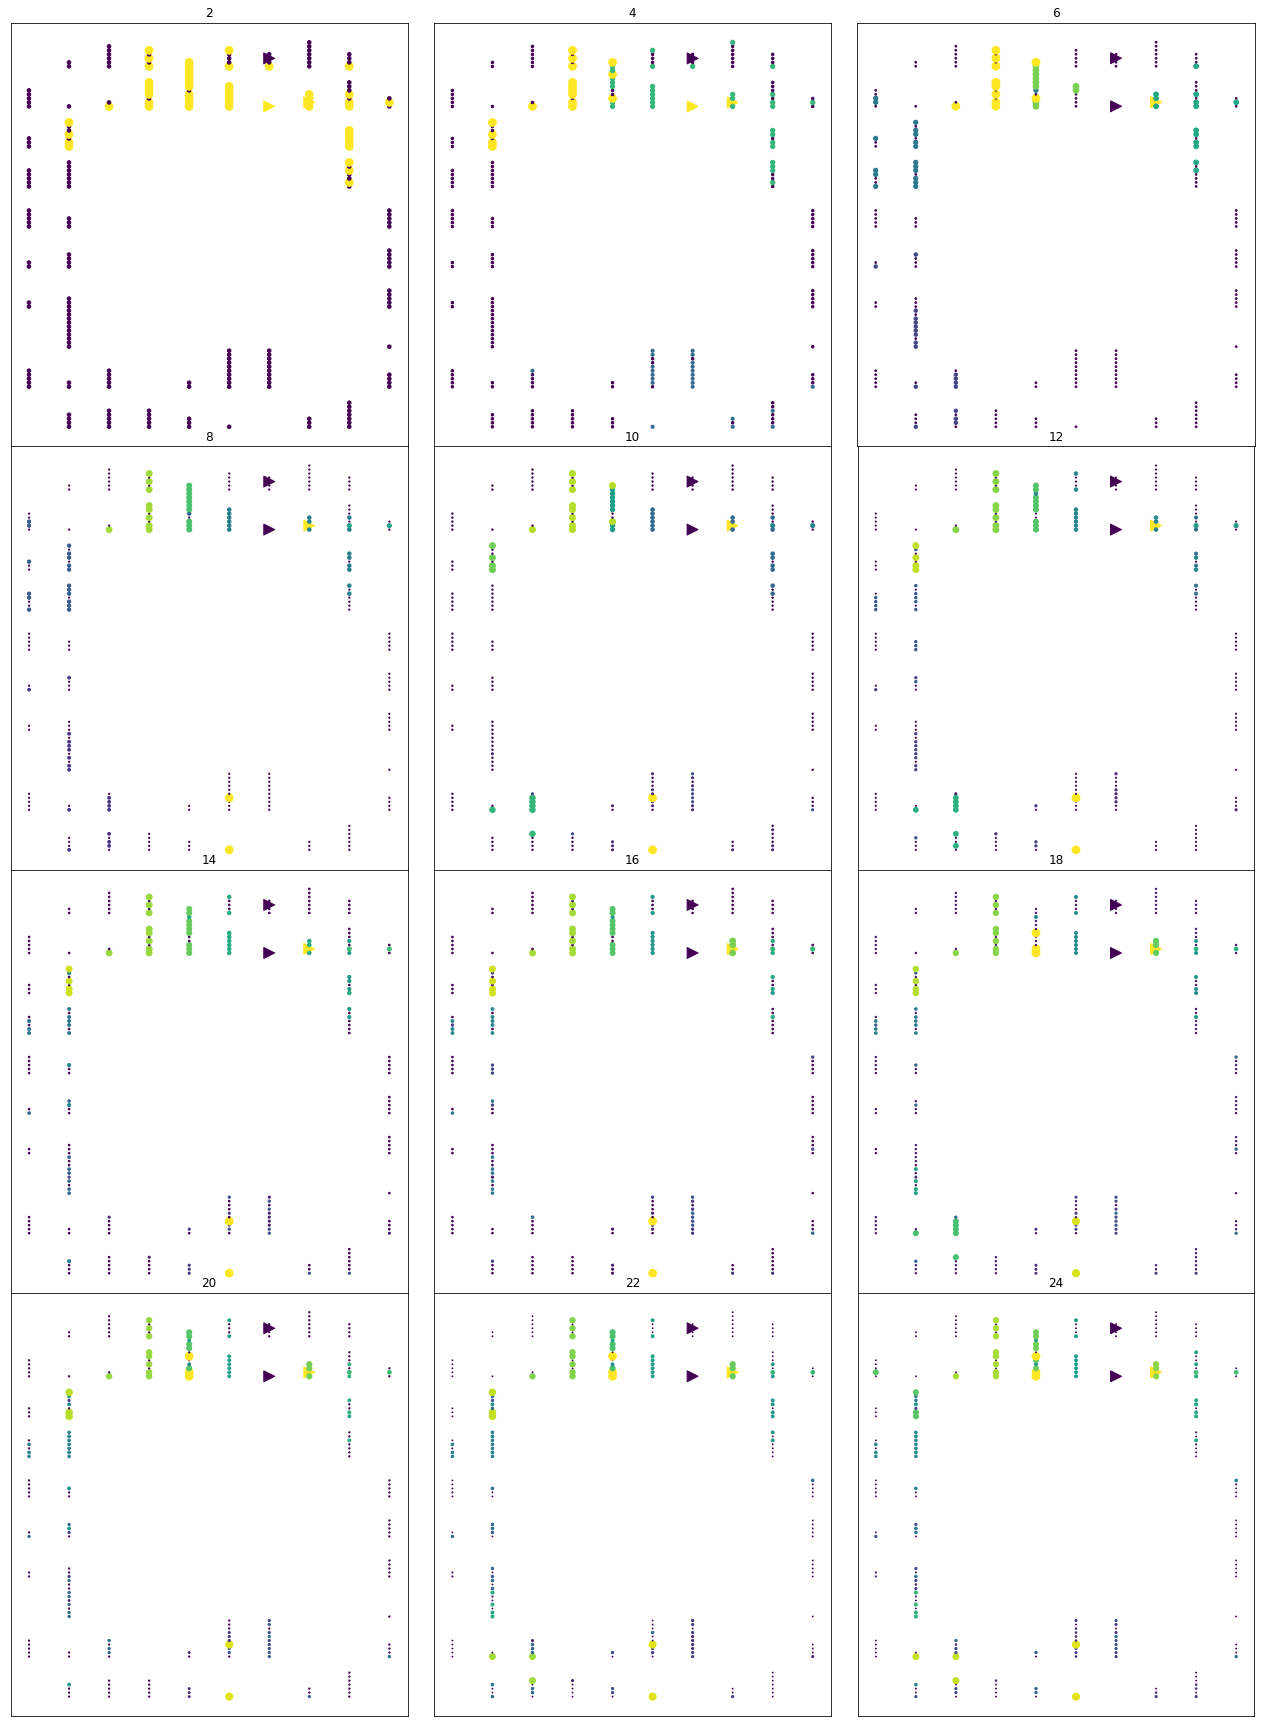

In [4]:
load_dir = "data"
projection = Projection(load_dir, "apex6", 34, include_tsne = True)

print(projection.cp)

min_i = 2
max_i = 20
step = 2
i_no = (max_i - min_i) / step + 1
x_dim = math.ceil(i_no ** 0.5)
y_dim = math.floor(i_no ** 0.5)

base_width = 6
fig, axes = plt.subplots(x_dim, y_dim, figsize = (base_width * y_dim, base_width * x_dim))
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0, hspace=0)

k = min_i
for row in axes:
    for col in row:
        col.set_xticks([], [])
        col.set_yticks([], [])
        col.set_title(str(k))
        projection.plot_clustered(k, 60, fig, col)
        k += step

Plot the t-SNE-labeled nodes on the FPGA grid. This uses the file generated in the last step of `embeddings.ipynb`

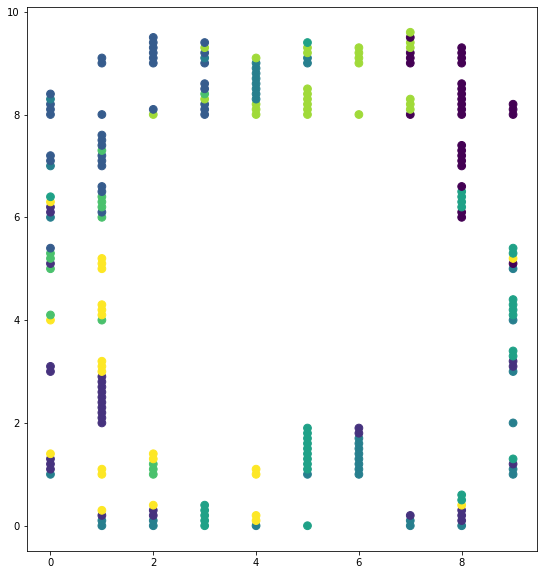

In [5]:
projection.plot_tsne()

Print out all heaviest-cluster weights.

In [6]:
circs = [("alu2", 30), ("alu2", 34), ("alu2", 36), ("alu2", 40), ("alu2", 42), ("alu2", 46),\
         ("apex6", 34), ("apex6", 38), ("apex6", 42), ("apex6", 46), ("apex6", 48), ("apex6", 52),\
         ("x1", 34), ("x1", 38), ("x1", 42), ("x1", 46), ("x1", 48), ("x1", 52)]
scatter_ys = []
for circ in circs:
    projection = Projection(load_dir, circ[0], circ[1])
    projection.cluster(16)
    mw = max([c[1] for c in projection.cls_list])
    print(circ, mw)
    scatter_ys.append(mw)

('alu2', 30) 0.3586291875
('alu2', 34) 0.1366874746696
('alu2', 36) 0.14678041287256471
('alu2', 40) 0.146718874556
('alu2', 42) 0.15589685135599998
('alu2', 46) 0.149897630032
('apex6', 34) 0.10288377791999999
('apex6', 38) 0.06896161352
('apex6', 42) 0.14034549929399998
('apex6', 46) 0.080775617341175
('apex6', 48) 0.15245459377200002
('apex6', 52) 0.0348131263816
('x1', 34) 0.14381658
('x1', 38) 0.130043445606
('x1', 42) 0.0597304206306
('x1', 46) 0.08417471869500001
('x1', 48) 0.0660303013608
('x1', 52) 0.098876140605


Print the postrouting delay increases.

In [7]:
scatter_xs = []
txt = ""
for benchmark in os.listdir(load_dir):
    if not os.path.isdir(load_dir + '/' + benchmark):
        continue
    for chanw in sorted(os.listdir(load_dir + '/' + benchmark)):
        log = open(load_dir + '/' + benchmark + '/' + chanw + "/log.txt")
        lines = log.readlines()
        log.close()
        diff = lines[0].split()[-1][1:-2]
        scatter_xs.append(float(diff))
        txt += benchmark + ' ' + chanw.split('.')[1] + ' ' + diff + "\n"

print(txt)

alu2 30 16.66
alu2 34 5.551
alu2 36 3.957
alu2 40 1.403
alu2 42 4.721
alu2 46 8.942
apex6 34 16.02
apex6 38 8.069
apex6 42 10.49
apex6 46 10.72
apex6 48 6.339
apex6 52 2.536
x1 34 8.326
x1 38 20.17
x1 42 4.643
x1 46 20.33
x1 48 8.167
x1 52 2.243



Plot a cluster weight versus the postrouting delay increase to better see any trends

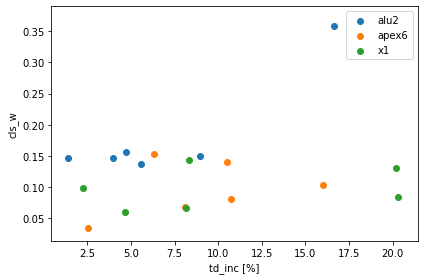

In [8]:
labels = ["alu2" for i in range(0, 6)]
labels += ["apex6" for i in range(0, 6)]
labels += ["x1" for i in range(0, 6)]

circs = ["alu2", "apex6", "x1"]
for i in range(0, len(circs)):
    subx = [scatter_xs[j] for j in range(0, len(scatter_xs)) if labels[j] == circs[i]]
    suby = [scatter_ys[j] for j in range(0, len(scatter_ys)) if labels[j] == circs[i]]
    plt.scatter(subx, suby, label = circs[i])
plt.legend()
plt.ylabel("cls_w")
plt.xlabel("td_inc [%]")
plt.tight_layout()
plt.show()

Plot the postplacement sink delays. Extracted from VPR's logs.

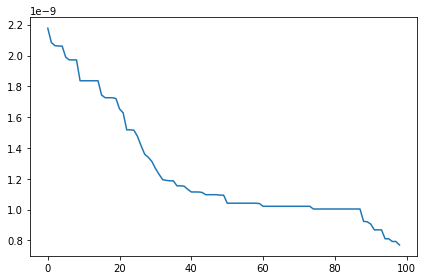

In [9]:
tds = [\
2.06146e-09,\
2.06146e-09,\
2.17694e-09,\
2.06399e-09,\
2.08407e-09,\
1.72055e-09,\
1.83599e-09,\
1.83599e-09,\
1.83599e-09,\
1.97152e-09,\
1.97152e-09,\
1.83599e-09,\
1.83599e-09,\
1.9891e-09,\
1.83599e-09,\
1.74312e-09,\
1.97152e-09,\
1.65318e-09,\
1.51513e-09,\
1.72594e-09,\
1.72594e-09,\
1.62808e-09,\
1.72594e-09,\
1.33946e-09,\
1.47499e-09,\
1.51765e-09,\
1.51765e-09,\
1.41475e-09,\
1.35955e-09,\
1.09388e-09,\
1.09388e-09,\
1.18675e-09,\
1.13155e-09,\
1.18675e-09,\
1.11147e-09,\
1.15413e-09,\
1.15413e-09,\
1.22941e-09,\
1.26708e-09,\
8.68413e-10,\
8.68413e-10,\
8.68413e-10,\
7.70547e-10,\
9.21159e-10,\
1.02152e-09,\
7.93126e-10,\
9.23657e-10,\
9.06076e-10,\
1.02152e-09,\
1.09681e-09,\
1.18968e-09,\
1.11439e-09,\
1.11439e-09,\
1.02152e-09,\
1.02152e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
8.10708e-10,\
1.19472e-09,\
1.0416e-09,\
1.31266e-09,\
1.00394e-09,\
1.0416e-09,\
1.0416e-09,\
1.09681e-09,\
1.02152e-09,\
1.03911e-09,\
1.02152e-09,\
1.02152e-09,\
1.02152e-09,\
1.02152e-09,\
1.11439e-09,\
7.93126e-10,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.00394e-09,\
1.15206e-09,\
1.09681e-09,\
1.00394e-09,\
1.02152e-09,\
1.02152e-09,\
1.00394e-09,\
1.0416e-09,\
1.0416e-09,\
1.0416e-09,\
1.0416e-09,\
1.0416e-09,\
1.0416e-09,\
1.09681e-09,\
1.02152e-09,\
8.10708e-10,\
1.02152e-09,\
1.02152e-09,\
]

plt.plot(sorted(tds, reverse = True))
plt.tight_layout()
plt.show()

Plot the postrouting sink delays. Extracted from VPR's logs.

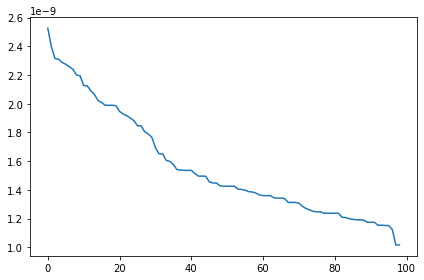

In [10]:
tds = [\
2.52576e-09,\
2.31494e-09,\
2.30997e-09,\
2.19452e-09,\
2.25723e-09,\
2.00919e-09,\
2.02173e-09,\
1.92886e-09,\
1.94644e-09,\
2.12463e-09,\
2.19992e-09,\
2.28779e-09,\
1.9891e-09,\
2.27521e-09,\
1.9891e-09,\
1.98657e-09,\
2.12713e-09,\
2.0899e-09,\
1.65065e-09,\
1.84643e-09,\
2.39609e-09,\
1.91672e-09,\
1.84643e-09,\
1.60553e-09,\
1.98953e-09,\
2.06482e-09,\
1.76613e-09,\
2.24051e-09,\
1.36494e-09,\
1.24699e-09,\
1.19179e-09,\
1.33986e-09,\
1.49547e-09,\
1.35994e-09,\
1.35994e-09,\
1.15413e-09,\
1.15413e-09,\
1.78911e-09,\
1.88198e-09,\
1.01653e-09,\
1.01653e-09,\
1.24742e-09,\
1.39803e-09,\
1.20976e-09,\
1.80458e-09,\
1.28505e-09,\
1.54106e-09,\
1.19222e-09,\
1.31266e-09,\
1.23738e-09,\
1.44819e-09,\
1.5988e-09,\
1.40553e-09,\
1.53606e-09,\
1.23738e-09,\
1.69417e-09,\
1.38545e-09,\
1.17463e-09,\
1.15206e-09,\
1.24992e-09,\
1.4959e-09,\
1.17463e-09,\
1.37795e-09,\
1.19971e-09,\
1.25995e-09,\
1.40303e-09,\
1.38795e-09,\
1.4959e-09,\
1.53856e-09,\
1.36037e-09,\
1.53606e-09,\
1.53606e-09,\
1.42561e-09,\
1.42561e-09,\
1.57622e-09,\
1.42561e-09,\
1.31266e-09,\
1.34279e-09,\
1.17463e-09,\
1.34279e-09,\
1.51348e-09,\
1.45574e-09,\
1.34529e-09,\
1.27e-09,\
1.15206e-09,\
1.89999e-09,\
1.65151e-09,\
1.20726e-09,\
1.23738e-09,\
1.23738e-09,\
1.12443e-09,\
1.42811e-09,\
1.42561e-09,\
1.19472e-09,\
1.30766e-09,\
1.23738e-09,\
1.18968e-09,\
1.31266e-09,\
1.44819e-09,\
]

plt.plot(sorted(tds, reverse = True))
plt.tight_layout()
plt.show()